# Open-loop Trajectory Generation: Differential Flatness

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from ipywidgets import interact
from utils import animate_planar_quad

# Problem Definition

In [2]:
class PlanarQuadrotorDynamics:

    def __init__(self):
        # Dynamics constants
        # yapf: disable
        self.g = 9.807         # gravity (m / s**2)
        self.m = 2.5           # mass (kg)
        self.l = 1.0           # half-length (m)
        self.I_zz = 1.0         # moment of inertia about the out-of-plane axis (kg * m**2)
        # yapf: enable

    def __call__(self, state, control):
        """Continuous-time dynamics of a planar quadrotor expressed as an ODE."""
        x, v_x, y, v_y, ϕ, ω = state
        T_1, T_2 = control
        return np.array([
            v_x,
            -(T_1 + T_2) * np.sin(ϕ) / self.m,
            v_y,
            (T_1 + T_2) * np.cos(ϕ) / self.m - self.g,
            ω,
            (T_2 - T_1) * self.l / self.I_zz,
        ])

In [3]:
dynamics = PlanarQuadrotorDynamics()
state_0 = np.array([4., 2., 6., 2., -np.pi / 4, -1.])
state_f = np.zeros(6)
t_f = 3  # fixed final time

# Direct Method

In [4]:
N = 60
dt = t_f / N

cost = lambda z: dt * np.sum(np.square(z.reshape(N + 1, 8)[:, -2:]))


def constraints(z):
    states_and_controls = z.reshape(N + 1, 8)
    states = states_and_controls[:, :6]
    controls = states_and_controls[:, -2:]
    constraint_list = [states[0] - state_0, states[-1] - state_f]
    for i in range(N):
        constraint_list.append(states[i + 1] - (states[i] + dt * dynamics(states[i], controls[i])))
    return np.concatenate(constraint_list)


z_guess = np.concatenate([np.linspace(state_0, state_f, N + 1), np.ones((N + 1, 2))], -1).ravel()
z_iterates = [z_guess]
result = minimize(cost,
                  z_guess,
                  constraints={
                      'type': 'eq',
                      'fun': constraints
                  },
                  options={'maxiter': 1000},
                  callback=lambda z: z_iterates.append(z))
z_iterates = np.stack(z_iterates)
result

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 1149.8288095969094
       x: [ 4.000e+00  2.000e+00 ... -3.825e-05 -3.825e-05]
     nit: 41
     jac: [ 0.000e+00  0.000e+00 ... -1.526e-05 -1.526e-05]
    nfev: 20053
    njev: 41

In [5]:
t = np.linspace(0, t_f, N + 1)
z = result.x.reshape(N + 1, 8)
animate_planar_quad(t, z[:, 0], z[:, 2], z[:, 4])

In [16]:
t = np.linspace(0, t_f, N + 1)
@interact(iteration=(0, len(z_iterates) - 1))
def f(iteration=0):
    z = z_iterates[iteration].reshape(N + 1, 8)
    return animate_planar_quad(t, z[:, 0], z[:, 2], z[:, 4])

interactive(children=(IntSlider(value=0, description='iteration', max=41), Output()), _dom_classes=('widget-in…

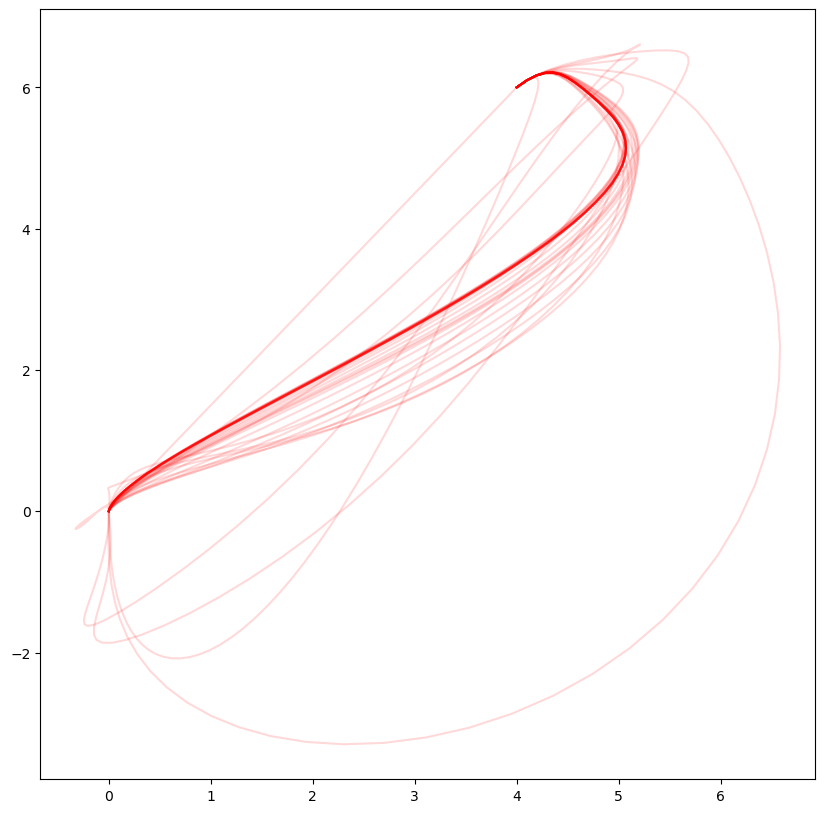

In [17]:
states_and_controls_iterates = z_iterates.reshape(-1, N + 1, 8)
plt.figure(figsize=(10, 10))
plt.plot(states_and_controls_iterates[:, :, 0].T, states_and_controls_iterates[:, :, 2].T, color='red', alpha=0.15);

# Differential Flatness

In [8]:
from numpy.polynomial import Polynomial

In [9]:
def get_flat_output_derivatives(state, ydd=0, yddd=0, g=dynamics.g):
    x, xd, y, yd, ϕ, ω = state
    xdd = -(ydd + g) * np.tan(ϕ)
    xddd = -(ω * ((ydd + g)**2 + xdd**2) - yddd * xdd) / (ydd + g)
    return np.array([x, xd, xdd, xddd]), np.array([y, yd, ydd, yddd])

In [10]:
basis_functions = [Polynomial.basis(i) for i in range(8)]
basis_matrix = np.array([[ψ.deriv(d)(0) for ψ in basis_functions] for d in range(4)] +
                        [[ψ.deriv(d)(t_f) for ψ in basis_functions] for d in range(4)])

In [11]:
x_poly = Polynomial(
    np.linalg.solve(basis_matrix,
                    np.concatenate([get_flat_output_derivatives(state_0)[0],
                                    get_flat_output_derivatives(state_f)[0]])))
y_poly = Polynomial(
    np.linalg.solve(basis_matrix,
                    np.concatenate([get_flat_output_derivatives(state_0)[1],
                                    get_flat_output_derivatives(state_f)[1]])))

In [12]:
x_poly

Polynomial([  4.        ,   2.        ,   4.9035    ,   3.269     ,
       -13.01687654,   8.30538272,  -2.07273594,   0.18508871], domain=[-1.,  1.], window=[-1.,  1.], symbol='x')

In [13]:
y_poly

Polynomial([ 6.00000000e+00,  2.00000000e+00, -3.40468394e-15, -7.40148683e-16,
       -4.07407407e+00,  3.18518519e+00, -8.72427984e-01,  8.23045267e-02], domain=[-1.,  1.], window=[-1.,  1.], symbol='x')

In [18]:
t = np.linspace(0, t_f, 30 * t_f)
animate_planar_quad(t,
                    x_poly(t),
                    y_poly(t),
                    np.arctan2(-x_poly.deriv(2)(t),
                               y_poly.deriv(2)(t) + dynamics.g))